In [6]:
#importing basic libraries
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import itertools 
from sklearn.metrics import *
from sklearn.model_selection import train_test_split 
warnings.filterwarnings('ignore')
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils import data

from sklearn.metrics import *


#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Tesla P4


In [0]:
class MyDataset(data.Dataset):
    def __init__(self,images):
        images = torch.tensor(images,dtype=torch.float)
        self.data = images.reshape(images.shape[0],-1)

    def __getitem__(self, idx):
        return(self.data[idx,:])
    
    def __len__(self):
        return(self.data.shape[0])

In [0]:
class VAE(nn.Module):
  def __init__(self,encoder_input_dm,K,dropout):
    super(VAE,self).__init__()
    self.encoder_input_dm = encoder_input_dm
    self.K = K
    self.encoder_input_layer = nn.Linear(self.encoder_input_dm,1024)
    self.encoder_hidden_layer1 = nn.Linear(1024,1024)
    self.encoder_hidden_layer2 = nn.Linear(1024,1024)
    self.encoder_hidden_layer3 = nn.Linear(1024,1024)
    self.encoder_hidden_layer4 = nn.Linear(1024,1024)
    self.latent_layer_mu = nn.Linear(1024,K)
    self.latent_layer_logvar = nn.Linear(1024,K)
    
    self.decoder_input_layer = nn.Linear(K,1024)
    self.decoder_hidden_layer1 = nn.Linear(1024,1024)
    self.decoder_hidden_layer2 = nn.Linear(1024,1024)
    self.decoder_hidden_layer3 = nn.Linear(1024,1024)
    self.decoder_hidden_layer4 = nn.Linear(1024,1024)
    self.decoder_output_layer = nn.Linear(1024,self.encoder_input_dm)

    self.encoder_act = nn.PReLU()
    self.decoder_act = nn.PReLU()

    self.dropout = dropout
    self.dd = nn.Dropout(self.dropout)

  
  def encode(self,x):
    x = self.encoder_input_layer(x)
    x = self.encoder_act(x)
    x = self.dd(x)

    x = self.encoder_hidden_layer1(x)
    x = self.encoder_act(x)
    x = self.dd(x)

    x = self.encoder_hidden_layer2(x)
    x = self.encoder_act(x)
    x = self.dd(x)
    
    x = self.encoder_hidden_layer2(x)
    x = self.encoder_act(x)
    x = self.dd(x)

    x = self.encoder_hidden_layer4(x)
    x = self.encoder_act(x)
    x = self.dd(x)

    return(self.latent_layer_mu(x),self.latent_layer_logvar(x))

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std 

  def decode(self,z):
    z = self.decoder_input_layer(z)
    z = self.decoder_act(z)
    z = self.dd(z)

    z = self.decoder_hidden_layer1(z)
    z = self.decoder_act(z)
    z = self.dd(z)

    z = self.decoder_hidden_layer2(z)
    z = self.decoder_act(z)
    z = self.dd(z)

    z = self.decoder_hidden_layer3(z)
    z = self.decoder_act(z)
    z = self.dd(z)

    z = self.decoder_hidden_layer4(z)
    z = self.decoder_act(z)
    z = self.dd(z)

    z = self.decoder_output_layer(z)
    return(F.sigmoid(z))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 784))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

    

In [0]:
class implement_VAE():
    def __init__(self,train_pickle,val_pickle,batch_size,ModelClass):
        train_dataset = MyDataset(pickle.load(open(train_pickle,"rb")))
        val_dataset = MyDataset(pickle.load(open(val_pickle,"rb")))
        self.train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=val_dataset.__len__(), shuffle=True)
        
    def train_vae(self,learning_rate,max_epochs,dropout,K):
        self.vae = VAE(encoder_input_dm=784,K=K,dropout=dropout).to(device)
        optimizer = optim.Adam(self.vae.parameters(), lr=learning_rate)
        self.train_loss_history = []
        self.val_loss_history = []
        
        epoch = 0
        rounds = 0
        early_stopping_rounds = 5
        stop = False
        self.best_loss = np.inf
    
        while ((epoch < max_epochs)&(stop==False)):
            train_loss = 0.0
            for x_train in self.train_loader:
                x_train = x_train.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = self.vae.forward(x_train)
                loss = self.loss_function(recon_batch,x_train, mu,logvar)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()

                self.train_loss_history.append(train_loss/len(self.train_loader.dataset))
            
            x_val = next(iter(self.val_loader))
            with torch.no_grad():
                x_val = x_val.to(device)
                recon_batch, mu, logvar = self.vae.forward(x_val)
                loss = self.loss_function(recon_batch,x_val, mu,logvar)
                avg_val_loss = loss.item()/len(self.val_loader.dataset)
                self.val_loss_history.append(avg_val_loss)
                
            if(avg_val_loss<self.best_loss):
                self.best_loss = avg_val_loss
                rounds = 0
            else:
                rounds += 1



            if(rounds>=early_stopping_rounds):
                stop=True


            if((epoch%5==0)|(stop==True)):

                print("----------------------------------------------------------------------------------")
                print("EPOCH:"+str(epoch))
                if(stop==True):
                    print("Training to be concluded after this epoch") 
                print("Average training loss per sample  = "+str(train_loss/len(self.train_loader.dataset)))
                print("Average Validation loss per sample  = "+str(avg_val_loss))

            epoch+=1
                
        #While loop ends   
        #self.plot_loss()   
        
    def loss_function(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def plot_loss(self):
        print("----------------------------------------------------------------------------------")
        plt.plot(self.train_loss_history)
        plt.plot(self.val_loss_history)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()  

----------------------------------------------------------------------------------
EPOCH:0
Average training loss per sample  = 415.84349249301675
Average Validation loss per sample  = 210.9304778696498
----------------------------------------------------------------------------------
EPOCH:5
Average training loss per sample  = 189.13543495610534
Average Validation loss per sample  = 187.1035992217899
----------------------------------------------------------------------------------
EPOCH:10
Average training loss per sample  = 188.6563790652434
Average Validation loss per sample  = 186.30227079280155
----------------------------------------------------------------------------------
EPOCH:15
Average training loss per sample  = 172.2872384402434
Average Validation loss per sample  = 169.52553501945525
----------------------------------------------------------------------------------
EPOCH:20
Average training loss per sample  = 161.98270837490023
Average Validation loss per sample  = 160.4

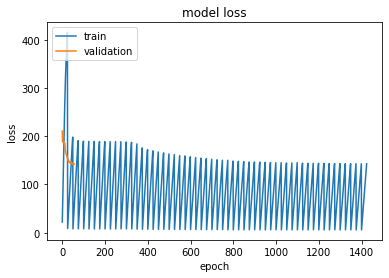

In [79]:
vl = implement_VAE(train_pickle="hw4_tr7.pkl",
                   val_pickle="hw4_te7.pkl",
                   batch_size=256,
                   ModelClass=VAE)
vl.train_vae(learning_rate=0.0001,
             max_epochs=200,
             dropout=0,
             K=4)

## Reconstructing Images from random distributions
We pick mean = 0 and std as 1 for our random dsitribution since the mean and std of the created latent vectors are approximately equal to these

In [0]:
n = 10 #number of images to reconstruct
K = 4  #value of K used in the autoencoder

#Creating random distribution
z_rand = torch.tensor(np.random.normal(0,1,size=(n,K)),dtype=torch.float).to(device)

RECONSTRUCTED IMAGES FOR RANDOM NOMRAL DISTRIBUTION


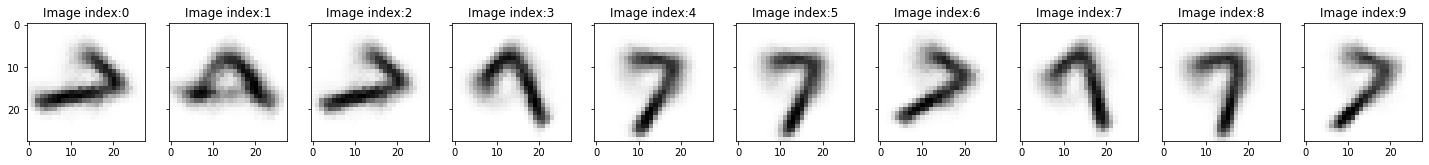

In [105]:
x_rand_recon = vl.vae.decode(z_rand)
x_rand_recon = x_rand_recon.reshape(-1,28,28).detach().cpu().numpy()
print("RECONSTRUCTED IMAGES FOR RANDOM NOMRAL DISTRIBUTION")
fig, axes = plt.subplots(1,n, 
                         figsize=(25,25),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect='equal'))

for idx in range(0,n):
  ax = axes[idx]
  # plot image on subplot
  img = x_rand_recon[idx,:,:]
  ax.imshow(img, cmap='gray_r')
  ax.set_title("Image index:"+str(idx))

## Evaluating which dimension among K is important(suppose it is  - i th dimension)
We do this by initializing z_rand such that z_rand[:,ic] has the same value where ic = range(0,K) and ic != i, where i also iterates over range(0,K). Thus if i th dimension is important, the reconstruction will be visibly poor and won't look like 7's

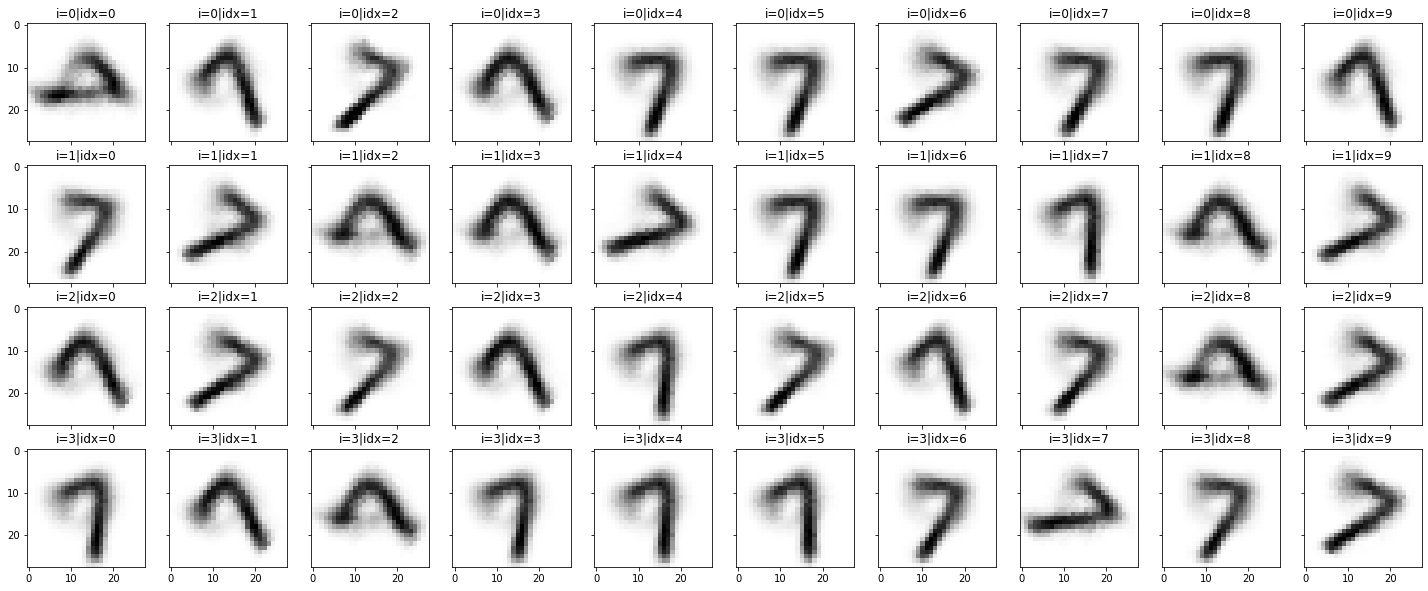

In [115]:
val_rand = np.random.normal(0,1,size=K)
x_rand_recon_overall = np.zeros((K,n,28,28))
for i in range(0,K):

  z_rand = np.zeros((n,K))
  for j in range(0,K):
    if(j==i):
      z_rand[:,j]=np.random.normal(0,1,size=(n))
    else:
      z_rand[:,j]=np.full((n),val_rand[j])
  z_rand = torch.tensor(np.random.normal(0,1,size=(n,K)),dtype=torch.float).to(device)

  
  x_rand_recon = vl.vae.decode(z_rand)
  x_rand_recon_overall[i,:,:,:] = x_rand_recon.reshape(-1,28,28).detach().cpu().numpy()
  
fig, axes = plt.subplots(K,n, 
                        figsize=(25,10),
                        sharex=True, sharey=True)
for i in range(0,K):
  for idx in range(0,n):
    ax = axes[i,idx]
    # plot image on subplot
    img = x_rand_recon_overall[i,idx,:,:]
    ax.imshow(img, cmap='gray_r')
    ax.set_title("i="+str(i)+"|idx="+str(idx))

We see that for i=2( 3rd dimension), the variation in terms of rotation is maximum, so we can say that this is the dimension of interest